# 🍷 Youth Alcohol Use Prediction Using Tree-Based Models
This notebook explores social, behavioral, and demographic factors contributing to alcohol consumption among youth using decision tree-based methods.

We use machine learning problem types:
- **Binary Classification** (Alcohol Use: Yes/No)
We evaluate Decision Tree, Bagging, Random Forest, and Gradient Boosting models using accuracy, F1-score, confusion matrices. 

In [20]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree,export_text
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor

In [37]:
df = pd.read_csv("youth_data.csv")

missing_codes = [91, 93, 94, 97, 98, 99, 991, 993, 994, 995, 996, 997, 998, 999]

df.replace(missing_codes, np.nan, inplace=True)

target = 'ALCFLAG'
predictors = [
    'EDUSCHGRD2', 'TOBFLAG', 'NEWRACE2', 'INCOME', 'POVERTY3',
    'HEALTH2', 'PRPROUD2', 'PRVDRGO2', 'PREVIOL2', 'FRDADLY2',
    'FRDMJMON', 'DRPRVME3', 'PRTALK3', 'TALKPROB', 'EDUSKPCOM', 'SCHFELT'
]
df = df.dropna(subset=[target] + predictors)

categorical_vars = ['EDUSCHGRD2', 'NEWRACE2', 'INCOME', 'POVERTY3']
for col in categorical_vars:
    df[col] = df[col].astype("category")

X = df[predictors]
y = df[target]

print("Class distribution (target):")
print(y.value_counts(normalize=True))
print(f"\nFinal cleaned data shape: {X.shape}")

Class distribution (target):
ALCFLAG
0    0.772133
1    0.227867
Name: proportion, dtype: float64

Final cleaned data shape: (7263, 16)


In [38]:
# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# For Class Imbalance 
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [5]:
# Decision Tree 

dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [7]:
tree_summary = export_text(dt_model, feature_names=X.columns.tolist())
print(tree_summary)

|--- TOBFLAG <= 0.50
|   |--- EDUSCHGRD2 <= 4.50
|   |   |--- FRDMJMON <= 1.50
|   |   |   |--- EDUSKPCOM <= 0.50
|   |   |   |   |--- PRPROUD2 <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- PRPROUD2 >  1.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- EDUSKPCOM >  0.50
|   |   |   |   |--- HEALTH2 <= 3.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- HEALTH2 >  3.50
|   |   |   |   |   |--- class: 1
|   |   |--- FRDMJMON >  1.50
|   |   |   |--- EDUSCHGRD2 <= 3.50
|   |   |   |   |--- HEALTH2 <= 1.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- HEALTH2 >  1.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- EDUSCHGRD2 >  3.50
|   |   |   |   |--- FRDADLY2 <= 1.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- FRDADLY2 >  1.50
|   |   |   |   |   |--- class: 0
|   |--- EDUSCHGRD2 >  4.50
|   |   |--- FRDMJMON <= 1.50
|   |   |   |--- EDUSCHGRD2 <= 6.50
|   |   |   |   |--- PRPROUD2 <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |  

In [8]:
importances = pd.DataFrame({'feature_name': X.columns, 'importance': dt_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)
print(importances)

   feature_name  importance
0       TOBFLAG    0.464843
1    EDUSCHGRD2    0.272010
2      FRDMJMON    0.151920
3     EDUSKPCOM    0.030171
4      PRPROUD2    0.027086
5      POVERTY3    0.018057
6        INCOME    0.015489
7       HEALTH2    0.014460
8      FRDADLY2    0.005141
9      NEWRACE2    0.000823
10     PRVDRGO2    0.000000
11     PREVIOL2    0.000000
12     DRPRVME3    0.000000
13      PRTALK3    0.000000
14     TALKPROB    0.000000
15      SCHFELT    0.000000


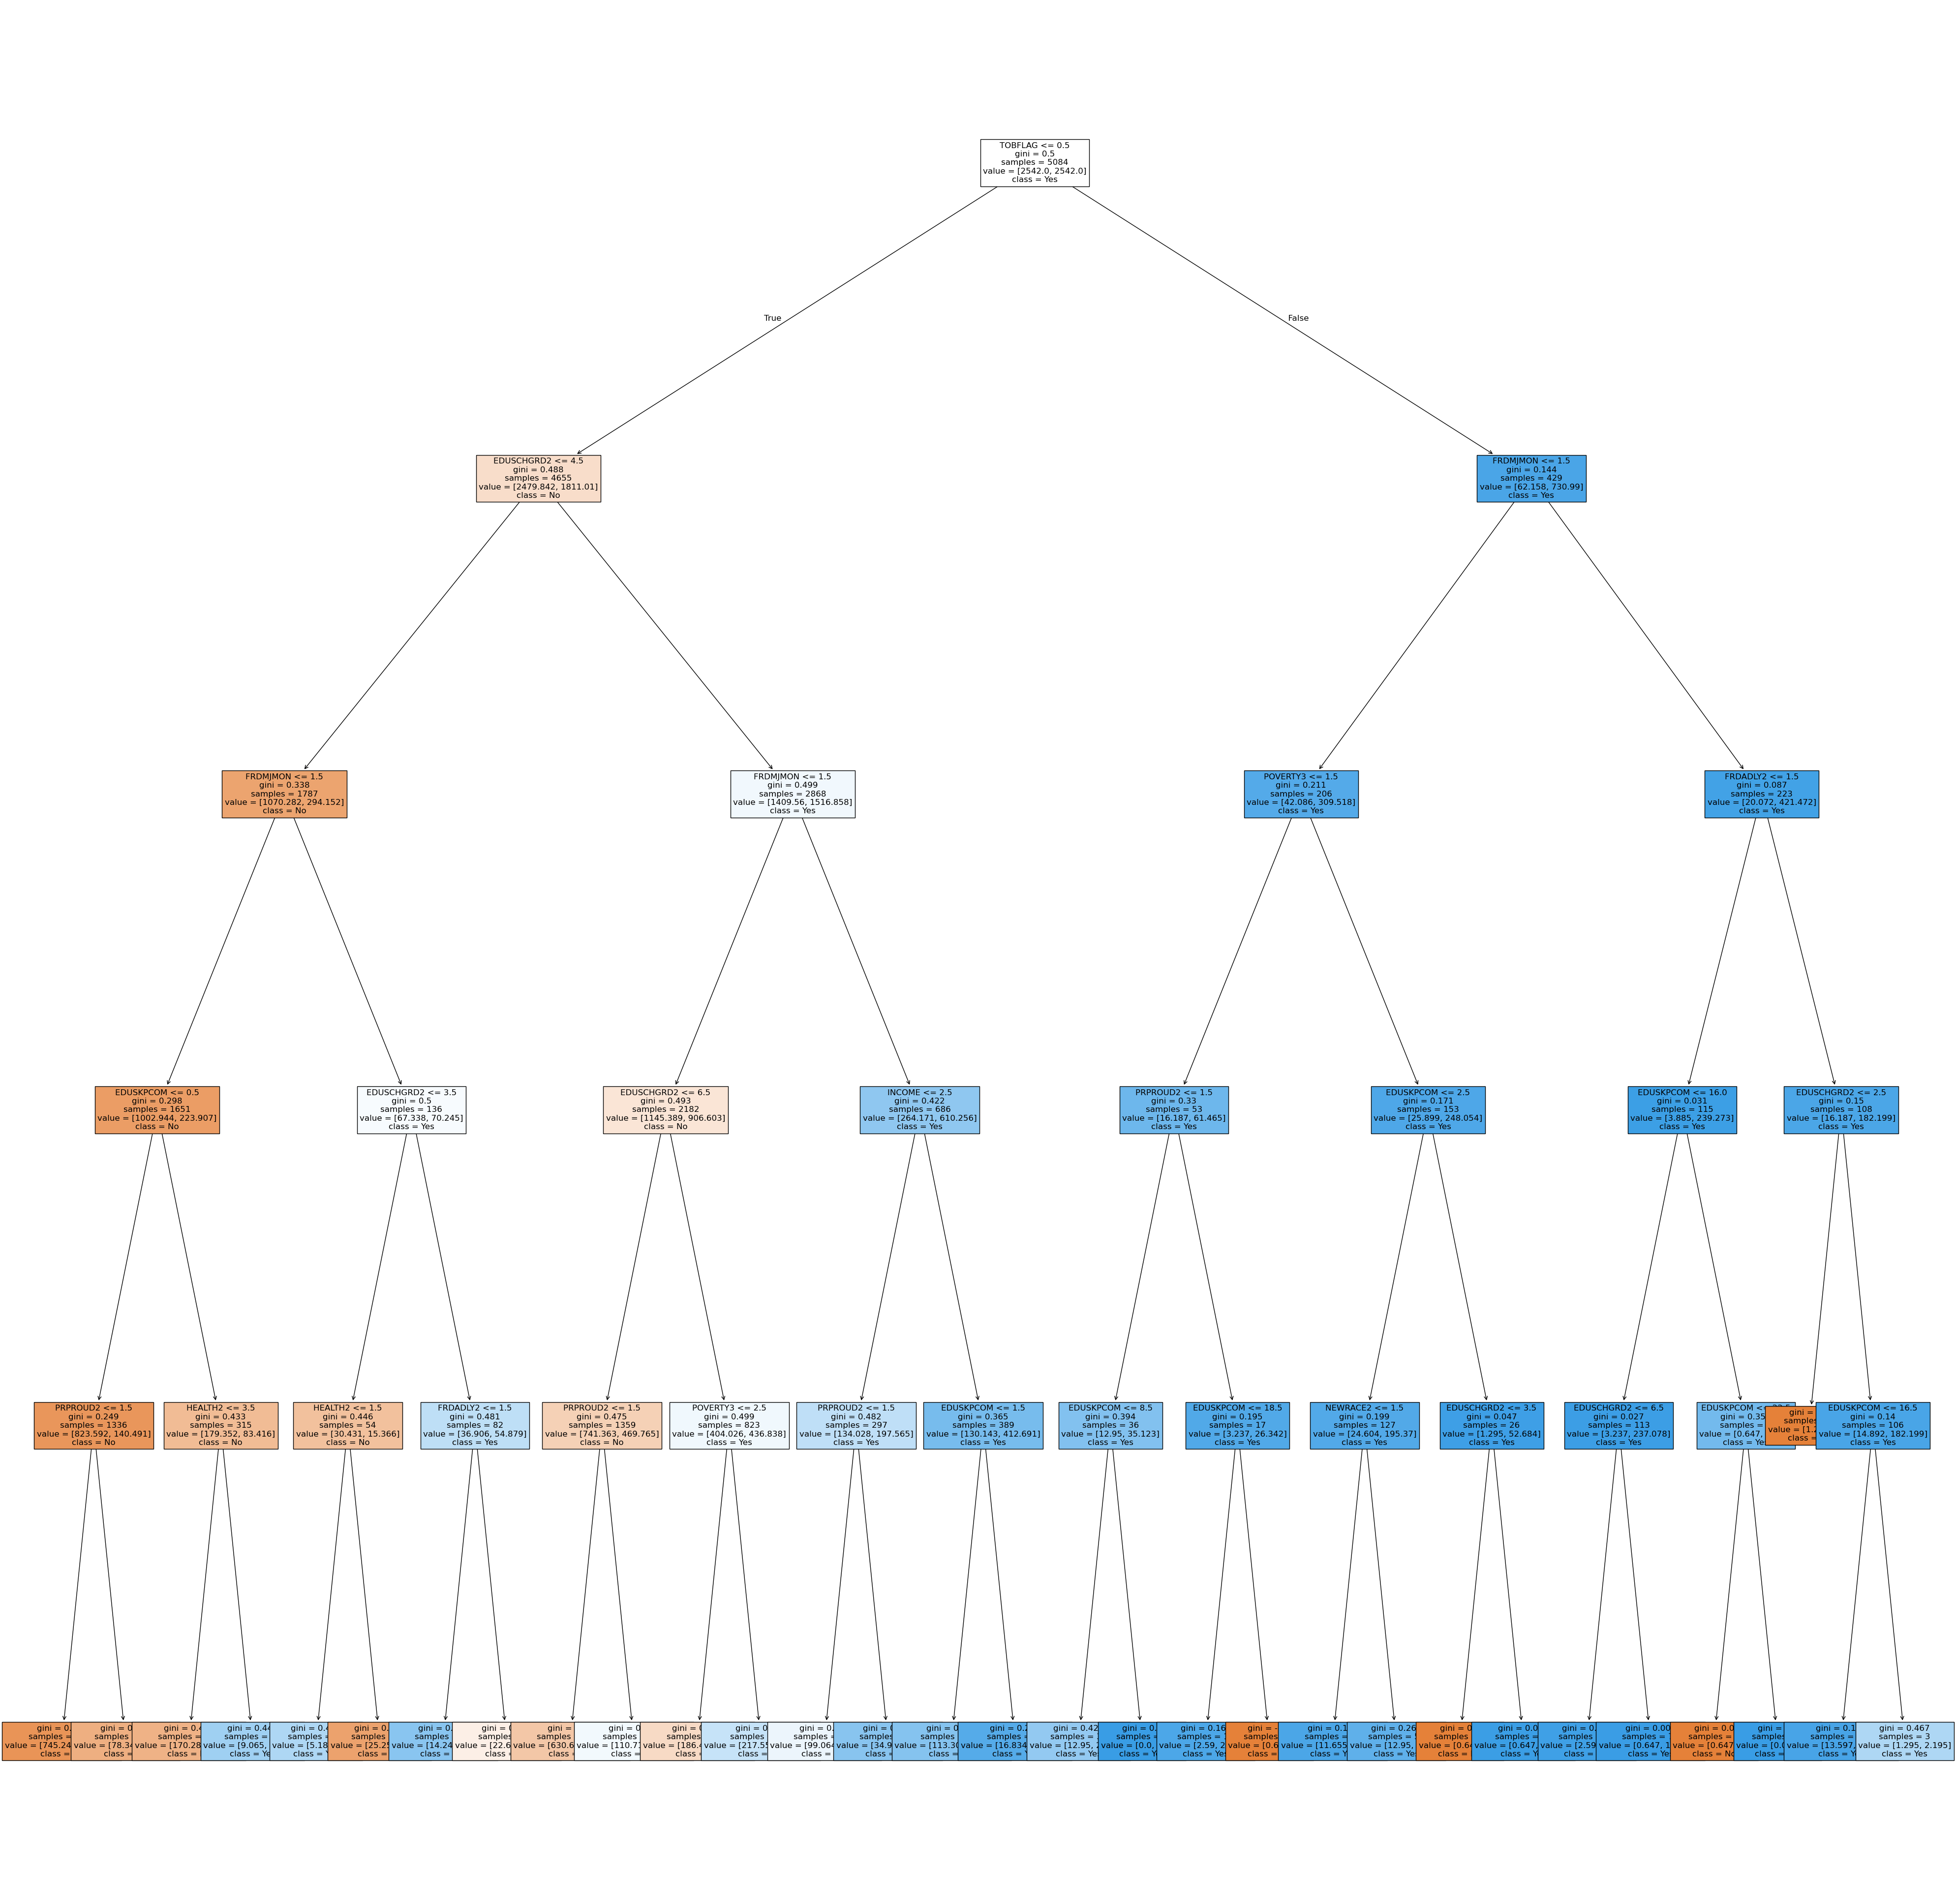

In [9]:
plt.figure(figsize=(50,50))
plot_tree(dt_model
          , filled=True
          , feature_names=X.columns
          , class_names=['No', 'Yes']
          , label='all'
          , fontsize=12)
plt.show()

In [10]:
accuracy = dt_model.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 72.83%


The Best Tree Size is : 2


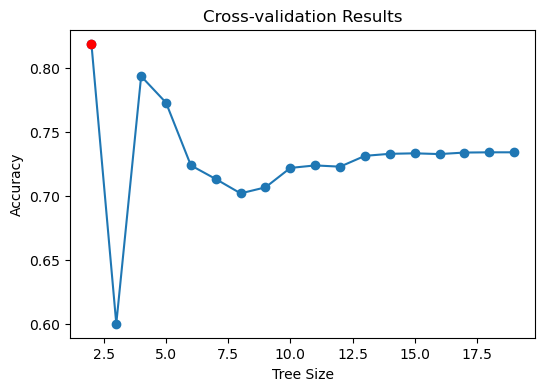

In [11]:
params = {'max_leaf_nodes': range(2, 20)}  
cv_binary = GridSearchCV(dt_model, params, cv=10)
cv_binary.fit(X_train, y_train)
cv_results = cv_binary.cv_results_

# find the best score for max leaf nodes
best_size = cv_binary.best_params_['max_leaf_nodes']
best_score = cv_binary.best_score_

# plot results of cross-validation
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');
print("The Best Tree Size is :", best_size)


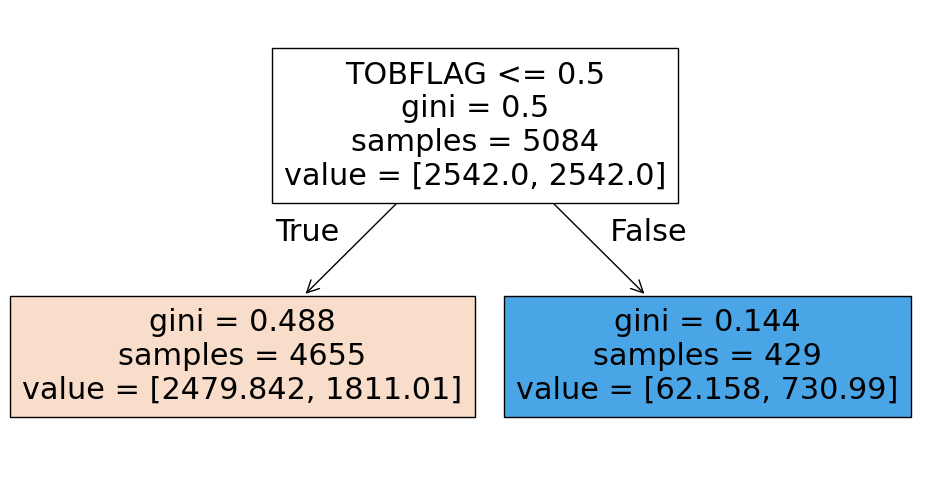

In [12]:
prune_binary = DecisionTreeClassifier(
    max_leaf_nodes=best_size,
    random_state=7,
    class_weight='balanced'
)
prune_binary.fit(X_train, y_train)

plt.figure(figsize=(12,6))
plt.title('Pruned Tree')
plot_tree(prune_binary, feature_names=X_train.columns, filled=True);

In [13]:
trees_summary = export_text(prune_binary, feature_names=X.columns.tolist())
print(trees_summary)

|--- TOBFLAG <= 0.50
|   |--- class: 0
|--- TOBFLAG >  0.50
|   |--- class: 1



In [14]:
y_pred = prune_binary.predict(X_test)

confusion_matrix = pd.crosstab(index=y_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

ALCFLAG     0    1
                  
0        1644  361
1          38  136


In [15]:
accuracy_prune = prune_binary.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy_prune*100))

Accuracy: 81.69%


In [17]:
# Random Forest 

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',  
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [18]:
# Gradient Boost(Boosting Model)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_gb = gb_model.predict(X_test)

In [32]:
#Classification Report 
models = {
    "Decision Tree": (dt_model, y_pred_dt),
    "Random Forest": (rf_model, y_pred_rf),
    "Gradient Boosting": (gb_model, y_pred_gb)
}

for name, (model, pred) in models.items():
    print(f"\n🧪 {name}")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("Classification Report:")
    print(classification_report(y_test, pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, pred))


🧪 Decision Tree
Accuracy: 0.7283157411656723
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1682
           1       0.44      0.71      0.55       497

    accuracy                           0.73      2179
   macro avg       0.67      0.72      0.68      2179
weighted avg       0.79      0.73      0.75      2179

Confusion Matrix:
[[1232  450]
 [ 142  355]]

🧪 Random Forest
Accuracy: 0.7806333180357963
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1682
           1       0.52      0.54      0.53       497

    accuracy                           0.78      2179
   macro avg       0.69      0.69      0.69      2179
weighted avg       0.78      0.78      0.78      2179

Confusion Matrix:
[[1435  247]
 [ 231  266]]

🧪 Gradient Boosting
Accuracy: 0.8219366681964204
Classification Report:
              precision    recall  f1-score  

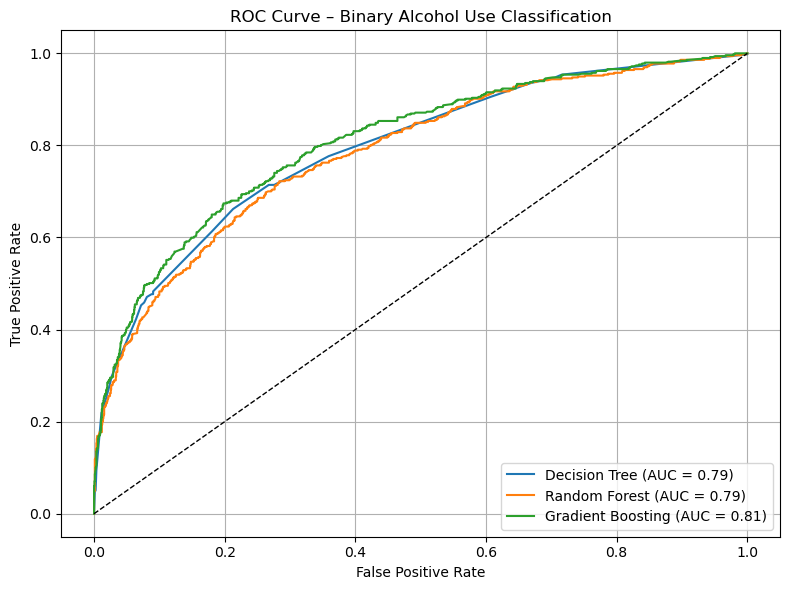

In [33]:
# Roc Curve 
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model[0], "predict_proba"):
        y_score = model[0].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc_score = roc_auc_score(y_test, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Binary Alcohol Use Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

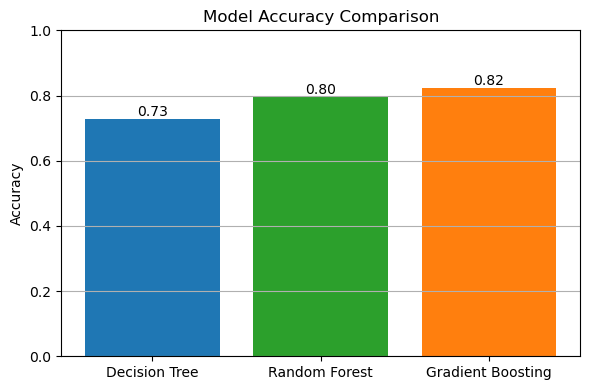

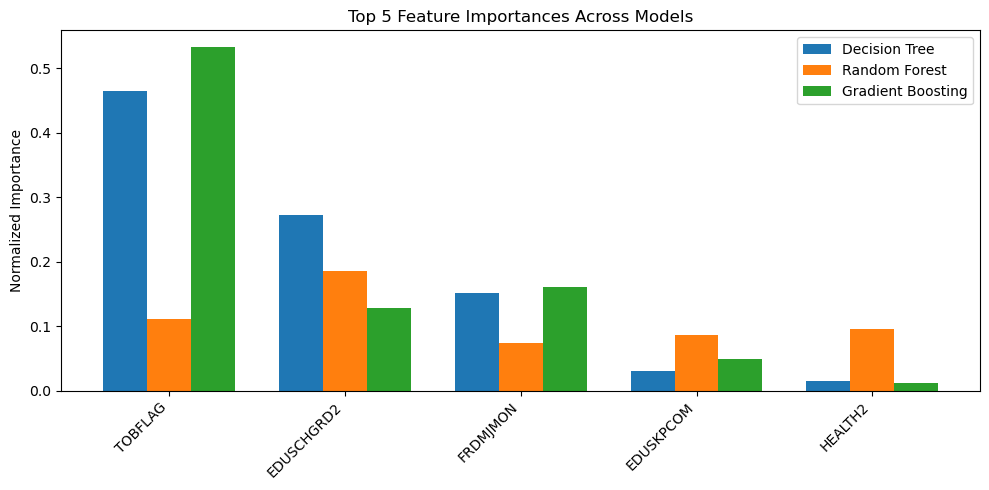

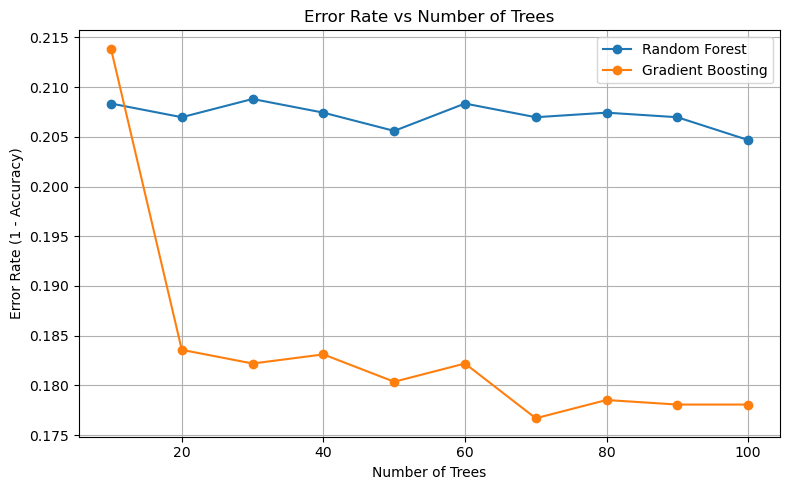

In [34]:
dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Accuracy Plot
accuracies = [
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_gb)
]
labels = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, accuracies, color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Feature Importances
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Decision Tree': dt_model.feature_importances_,
    'Random Forest': rf_model.feature_importances_,
    'Gradient Boosting': gb_model.feature_importances_
})
importance_df[['Decision Tree', 'Random Forest', 'Gradient Boosting']] = importance_df[
    ['Decision Tree', 'Random Forest', 'Gradient Boosting']
].div(importance_df[['Decision Tree', 'Random Forest', 'Gradient Boosting']].sum(), axis=1)
importance_df['Average'] = importance_df[['Decision Tree', 'Random Forest', 'Gradient Boosting']].mean(axis=1)
importance_df = importance_df.sort_values('Average', ascending=False).head(5)

# Plot Feature Importances
x = np.arange(len(importance_df))
width = 0.25
plt.figure(figsize=(10, 5))
plt.bar(x - width, importance_df['Decision Tree'], width=width, label='Decision Tree')
plt.bar(x, importance_df['Random Forest'], width=width, label='Random Forest')
plt.bar(x + width, importance_df['Gradient Boosting'], width=width, label='Gradient Boosting')
plt.xticks(x, importance_df['Feature'], rotation=45, ha='right')
plt.ylabel("Normalized Importance")
plt.title("Top 5 Feature Importances Across Models")
plt.legend()
plt.tight_layout()
plt.show()

# Error vs. n_estimators
tree_range = range(10, 110, 10)
bag_err, rf_err, gb_err = [], [], []
for n in tree_range:
    rf = RandomForestClassifier(n_estimators=n, max_features='sqrt', class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    gb = GradientBoostingClassifier(n_estimators=n, learning_rate=0.05, max_depth=3, random_state=42)
    gb.fit(X_train, y_train)
    
    rf_err.append(1 - accuracy_score(y_test, rf.predict(X_test)))
    gb_err.append(1 - accuracy_score(y_test, gb.predict(X_test)))

# Plot Error vs Trees
plt.figure(figsize=(8, 5))
plt.plot(tree_range, rf_err, marker='o', label='Random Forest')
plt.plot(tree_range, gb_err, marker='o', label='Gradient Boosting')
plt.xlabel("Number of Trees")
plt.ylabel("Error Rate (1 - Accuracy)")
plt.title("Error Rate vs Number of Trees")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📊 Random Forest Results (Tuned)
Best Params: {'max_depth': 10, 'max_features': None, 'n_estimators': 150}
Accuracy: 0.7806333180357963
Confusion Matrix:
 [[1435  247]
 [ 231  266]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      1682
           1       0.52      0.54      0.53       497

    accuracy                           0.78      2179
   macro avg       0.69      0.69      0.69      2179
weighted avg       0.78      0.78      0.78      2179



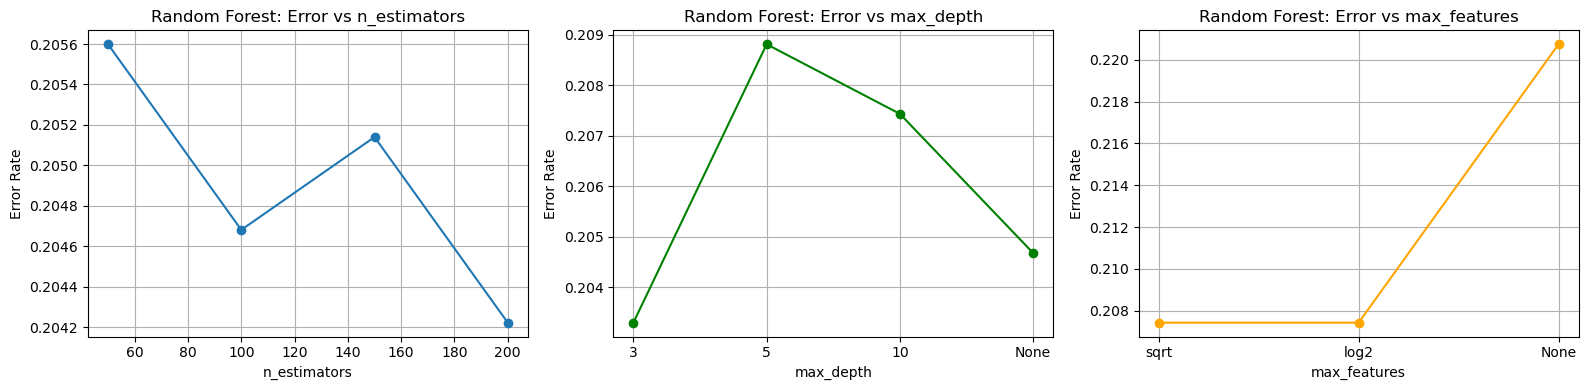

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define parameter grid
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Grid Search for best parameters
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=rf_params,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_

# Predict and report results
y_pred_rf = rf_model.predict(X_test)
print("\n📊 Random Forest Results (Tuned)")
print("Best Params:", rf_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# --- Manual tuning diagnostics ---

# Tuning values
rf_estimators = [50, 100, 150, 200]
rf_depths = [3, 5, 10, None]
rf_max_features_options = ['sqrt', 'log2', None]

# Error lists
rf_errors_estimators, rf_errors_depth, rf_errors_max_features = [], [], []

# Error vs n_estimators
for n in rf_estimators:
    model = RandomForestClassifier(
        n_estimators=n,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rf_errors_estimators.append(1 - accuracy_score(y_test, y_pred))

# Error vs max_depth
for d in rf_depths:
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=d,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rf_errors_depth.append(1 - accuracy_score(y_test, y_pred))

# Error vs max_features
for mf in rf_max_features_options:
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features=mf,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rf_errors_max_features.append(1 - accuracy_score(y_test, y_pred))

# Plot all 3 tuning diagnostics in one row
plt.figure(figsize=(16, 4))

# Plot: Error vs n_estimators
plt.subplot(1, 3, 1)
plt.plot(rf_estimators, rf_errors_estimators, marker='o')
plt.title("Random Forest: Error vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Error Rate")
plt.grid(True)

# Plot: Error vs max_depth
plt.subplot(1, 3, 2)
plt.plot([str(d) for d in rf_depths], rf_errors_depth, marker='o', color='green')
plt.title("Random Forest: Error vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("Error Rate")
plt.grid(True)

# Plot: Error vs max_features
plt.subplot(1, 3, 3)
plt.plot([str(mf) for mf in rf_max_features_options], rf_errors_max_features, marker='o', color='orange')
plt.title("Random Forest: Error vs max_features")
plt.xlabel("max_features")
plt.ylabel("Error Rate")
plt.grid(True)

plt.tight_layout()
plt.show()

 Gradient Boosting Results (Tuned)
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.8054153281321708
Confusion Matrix:
 [[1495  187]
 [ 237  260]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88      1682
           1       0.58      0.52      0.55       497

    accuracy                           0.81      2179
   macro avg       0.72      0.71      0.71      2179
weighted avg       0.80      0.81      0.80      2179



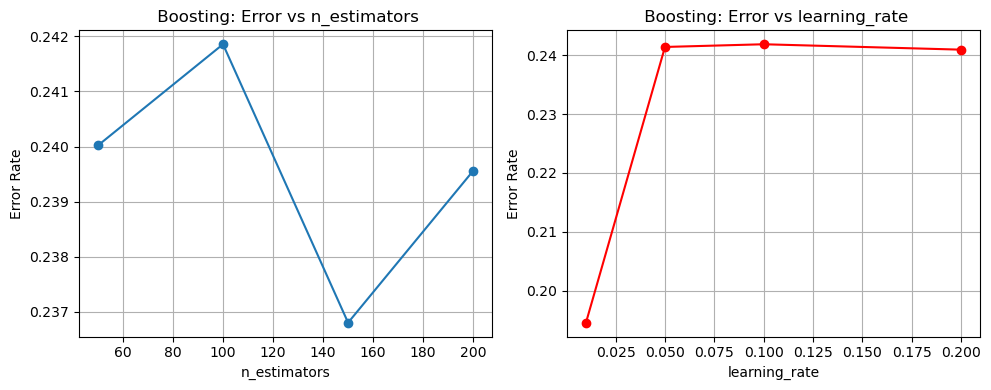

In [35]:

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_gb = gb_model.predict(X_test)


gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5]
}

gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

gb_grid.fit(X_train, y_train, sample_weight=sample_weights)
gb_model = gb_grid.best_estimator_
y_pred_gb = gb_model.predict(X_test)

print(" Gradient Boosting Results (Tuned)")
print("Best Params:", gb_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))


gb_estimators = [50, 100, 150, 200]
gb_lrs = [0.01, 0.05, 0.1, 0.2]
gb_errors_estimators, gb_errors_lr = [], []

for n in gb_estimators:
    model = GradientBoostingClassifier(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    gb_errors_estimators.append(1 - accuracy_score(y_test, y_pred))

for lr in gb_lrs:
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=lr,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    gb_errors_lr.append(1 - accuracy_score(y_test, y_pred))


plt.figure(figsize=(10, 4))

# Error vs n_estimators
plt.subplot(1, 2, 1)
plt.plot(gb_estimators, gb_errors_estimators, marker='o')
plt.title(" Boosting: Error vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Error Rate")
plt.grid(True)

# Error vs learning_rate
plt.subplot(1, 2, 2)
plt.plot(gb_lrs, gb_errors_lr, marker='o', color='red')
plt.title(" Boosting: Error vs learning_rate")
plt.xlabel("learning_rate")
plt.ylabel("Error Rate")
plt.grid(True)

plt.tight_layout()
plt.show()

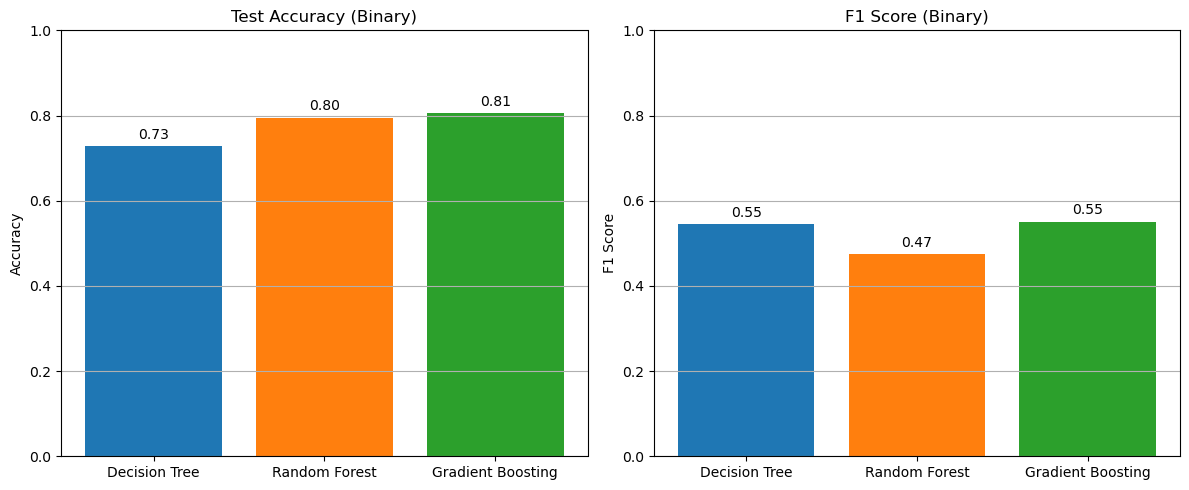

In [39]:
from sklearn.metrics import accuracy_score, f1_score

# Predict on test set
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Accuracy scores
accuracy_scores = [
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_gb)
]

# Binary F1 scores (use average='binary')
f1_scores = [
    f1_score(y_test, y_pred_dt),
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_gb)
]

models = ['Decision Tree',  'Random Forest', 'Gradient Boosting']

# Plotting
plt.figure(figsize=(12, 5))

# Accuracy Bar Plot
plt.subplot(1, 2, 1)
bars1 = plt.bar(models, accuracy_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Test Accuracy (Binary)")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis='y')
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.2f}", ha='center', va='bottom', fontsize=10)

# F1 Score Bar Plot
plt.subplot(1, 2, 2)
bars2 = plt.bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("F1 Score (Binary)")
plt.ylabel("F1 Score")
plt.ylim(0, 1.0)
plt.grid(axis='y')
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 📌 Conclusions (Binary Classification)

- **Top predictors**: Education level, tobacco use, parental communication  
- **Best model**: Random Forest (highest accuracy and balanced performance)  
- **Limitations**: Class imbalance and misencoded categoricals  
- **Next steps**:
  - Try SMOTE or stratified sampling  
  - Improve encoding of categorical features  
  - Consider simpler or more interpretable models